In [62]:
#Configuro el Google Colab
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [63]:
#Importo librerias
!pip install -U statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [64]:
#Importo librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [65]:
#Cargo mis datos
df = pd.read_excel("/content/gdrive/MyDrive/Maestria/Segundo Semestre/Metodos Estadisticos Avanzados/ACCIONES.xlsx", index_col=0, parse_dates= True)

In [66]:
#Solo traigo mis datos de las acciones
df1 = df[["AAPL"]]

In [67]:
df1.head()

,AAPL
Date,
1986-03-01,0.13
1986-04-01,0.14
1986-05-01,0.17
1986-06-01,0.16
1986-07-01,0.14


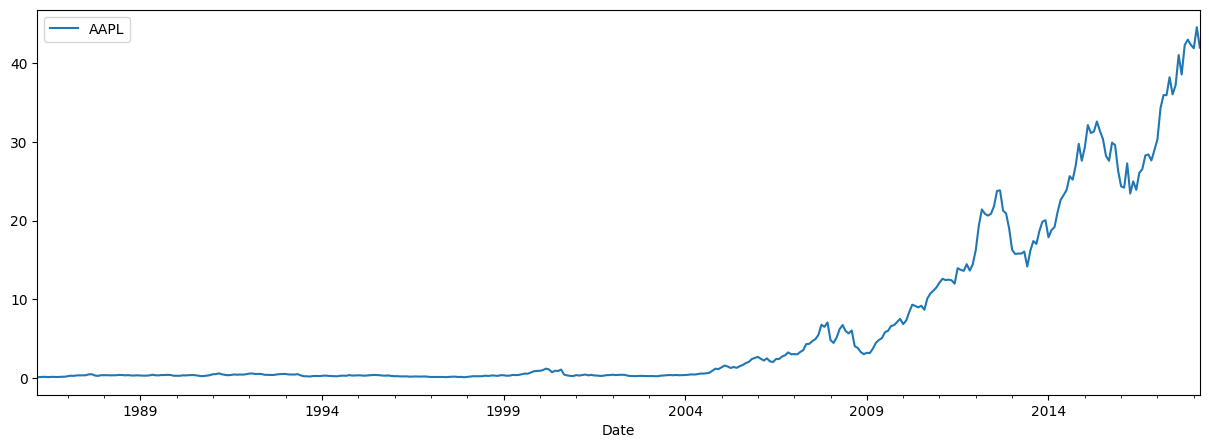

In [68]:
#Grafico mis datos en el tiempo
df1.plot(figsize=(15,5));

In [69]:
#Saco las diferencias de mi modelo con el codifo .diff() con el cual al dato actual le resto el anterior, esto lo hacemos para hacer estacionaria una serie no estacionaria 
#y para eliminar las tendencias
df1['lstdiff'] = df1['AAPL'].diff()

<ipython-input-69-37873dcf611b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['lstdiff'] = df1['AAPL'].diff()


<Axes: xlabel='Date'>

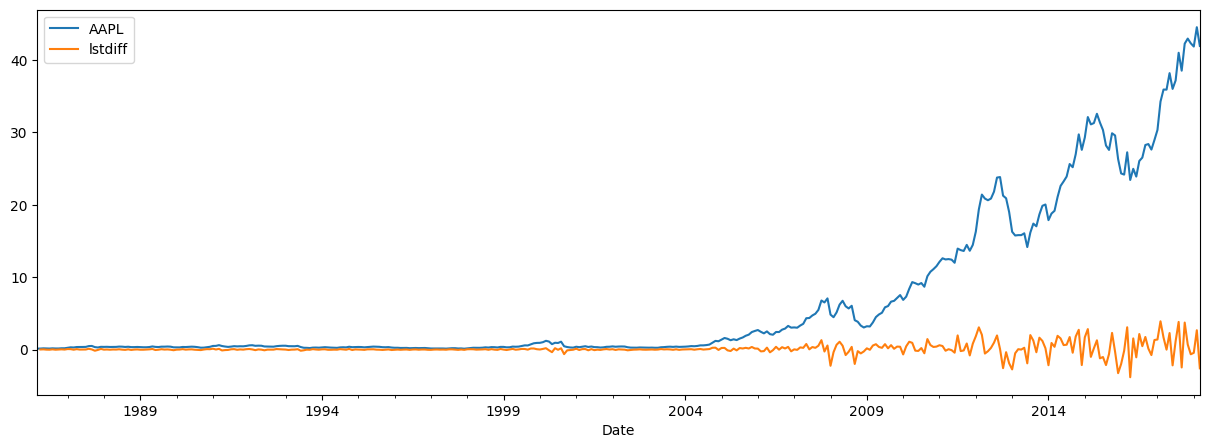

In [70]:
#Grafico ambas series para compararlas
df1.plot(figsize = (15,5))

In [71]:
#Ahora le saco el Logaritmo natural a los valores originales
df1['LogAAPL'] = np.log(df['AAPL'])

<ipython-input-71-e50244fbd70e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['LogAAPL'] = np.log(df['AAPL'])


<Axes: xlabel='Date'>

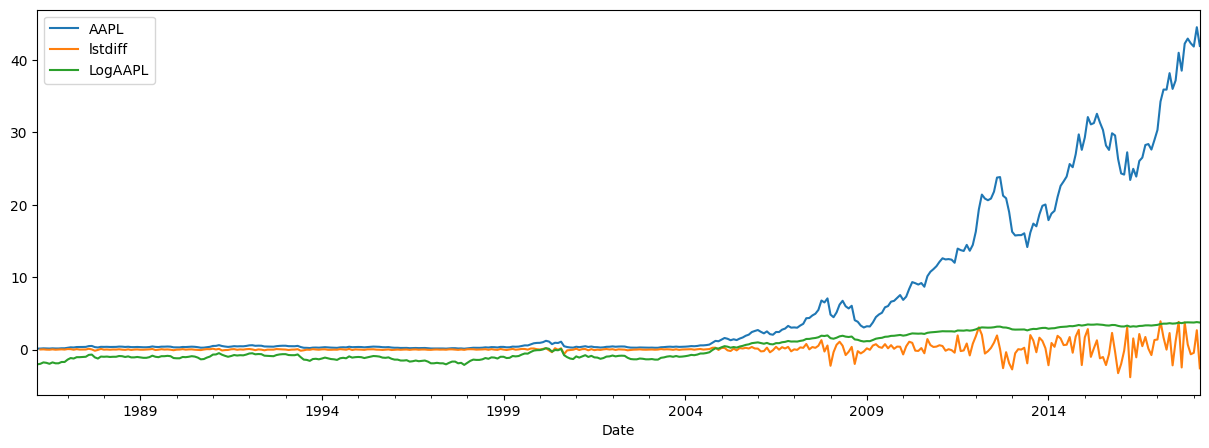

In [72]:
#Grafico los valores junto con el logaritmo
df1.plot(figsize= (15,5))

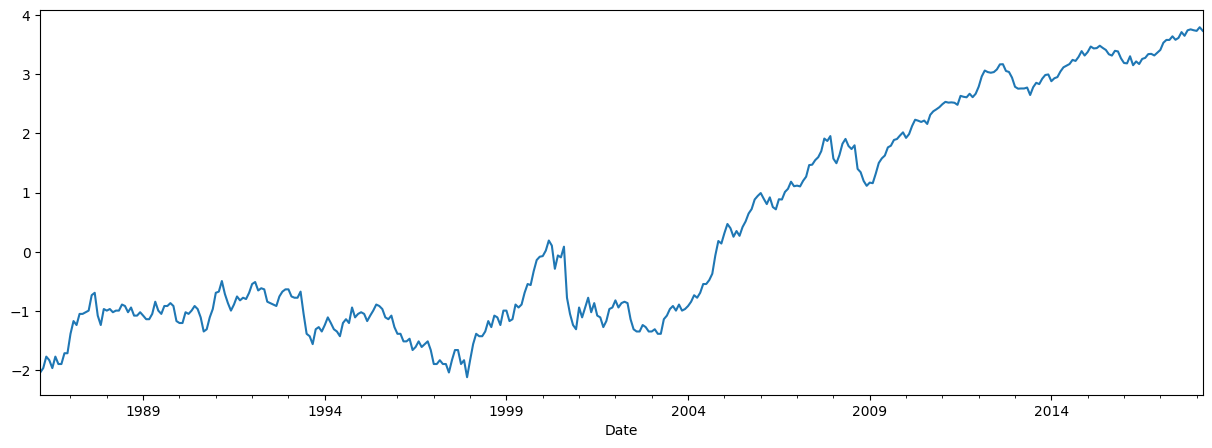

In [73]:
#Grafico solo el logaritmo
df1['LogAAPL'].plot(figsize=(15,5));

In [74]:
#Extra, saco las diferencias al logaritmo para ver como si elimino la tendencia que existia en nada más el logaritmo
df1['logdiff'] = df1['LogAAPL'].diff(periods=1)

<ipython-input-74-34b396fe5a19>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['logdiff'] = df1['LogAAPL'].diff(periods=1)


<Axes: xlabel='Date'>

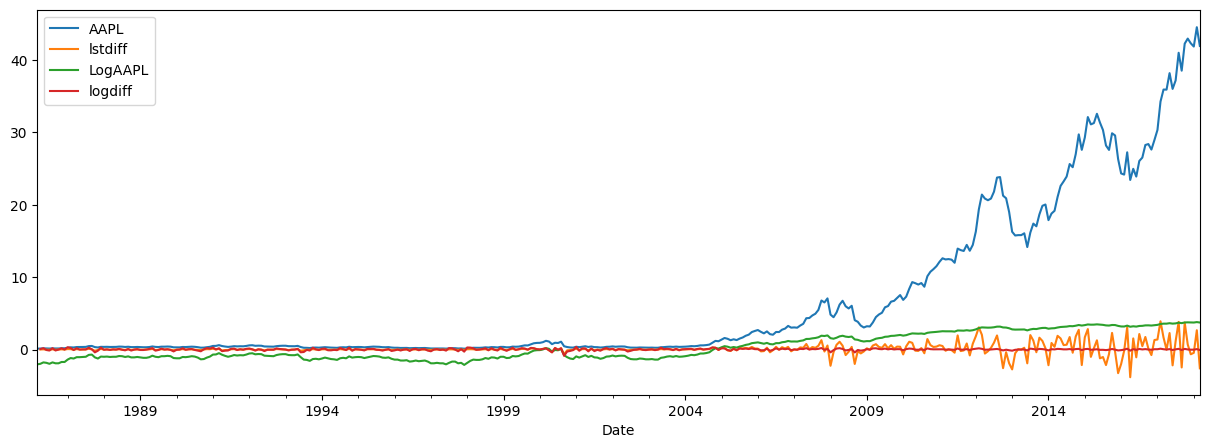

In [75]:
#Grafico con la diferencia del logaritmo
df1.plot(figsize= (15,5))

Parese ser que la mejor forma de hacer la serie lo mas estacionaria posible es primero sacando el logaritmo de la variable independiente en este caso la acción de Apple y luego sacar la diferencia de el logartimo ya que es la que más se aplana o tiene una media y varianza constante

Ahora quiero verificar si la serie es estasionaria o no con un test de DF y un KPPS sobre la diferencia de los logaritmos.

In [76]:
print(df1.isna().sum())
#ya que tengo 1 dato perdido lo que voy a hacer es eliminarlo para ver si mi serie es estacionaria o no con la diferencia de los errores
df1 = df1.dropna()
print(df1.isna().sum())

AAPL       0
lstdiff    1
LogAAPL    0
logdiff    1
dtype: int64
AAPL       0
lstdiff    0
LogAAPL    0
logdiff    0
dtype: int64


In [77]:
from statsmodels.tsa.stattools import adfuller, kpss

# ADF Test (Test de Dickey  Fuller)
result = adfuller(df1.logdiff.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test 
result = kpss(df1.logdiff.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')

ADF Statistic: -18.391267901829313
p-value: 2.2005365247823848e-30
Critial Values:
   1%, -3.44753973676872
Critial Values:
   5%, -2.8691160516676844
Critial Values:
   10%, -2.57080585953957

KPSS Statistic: 0.134525
p-value: 0.100000
Critial Values:
Critial Values:
Critial Values:
Critial Values:


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Por lo que se puede observar dados los resultados del test de DF y del KPSS podemos ver que la serie de tiempo cuando le sacamos el logaritmo natural y una diferencia al precio de la accion de Apple es estacionaria y debe ser el dato que debemos usar.

In [78]:
#Importamos el modelo ARIMA que usaremos despues  
from statsmodels.tsa.arima.model import ARIMA

In [79]:
#Dividimos el dataset en dos partes una de testeo y otra de entrenamiento donde dejamos los ultimos doce meses de entrenamiento
df1.index.freq = 'MS'

Ntest = 12

train = df1.iloc[:-Ntest]
test = df1.iloc[-Ntest:]

In [80]:
train.shape

(372, 4)

In [81]:
test.shape

(12, 4)

In [82]:
#Observo como queda mi set de testeo
test

,AAPL,lstdiff,LogAAPL,logdiff
Date,,,,
2017-04-01,35.91,-0.01,3.581016,-0.000278
2017-05-01,38.19,2.28,3.642574,0.061558
2017-06-01,36.01,-2.18,3.583797,-0.058777
2017-07-01,37.18,1.17,3.615771,0.031974
2017-08-01,41.00,3.82,3.713572,0.097801
2017-09-01,38.53,-2.47,3.651437,-0.062135
2017-10-01,42.26,3.73,3.743841,0.092404
2017-11-01,42.96,0.70,3.760269,0.016428
2017-12-01,42.31,-0.65,3.745023,-0.015246


In [83]:
train_idx = df1.index <= train.index[-1]
test_idx = df1.index > train.index[-1]

In [84]:
train_idx

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [85]:
#Creo mi modelo como un modelo ARIMA que puede ser considerado como un modelo AR de orden 1 con los valores reales de la acción de AAPL
arima = ARIMA(train['AAPL'], order =(1,0,0))

In [86]:
#Saco los resultados del modelo
arima_result = arima.fit()

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [87]:
#Llevo los datos obtenidos de entrenamiento a el dataframe que estoy trabajando
df1.loc[train_idx, 'AR(1)'] = arima_result.predict(start = train.index[0], end= train.index[-1])

<ipython-input-87-c8832ed331ba>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.loc[train_idx, 'AR(1)'] = arima_result.predict(start = train.index[0], end= train.index[-1])


In [88]:
df1.head()

,AAPL,lstdiff,LogAAPL,logdiff,AR(1)
Date,,,,,
1986-04-01,0.14,0.01,-1.966113,0.074108,16.049751
1986-05-01,0.17,0.03,-1.771957,0.194156,0.156126
1986-06-01,0.16,-0.01,-1.832581,-0.060625,0.186096
1986-07-01,0.14,-0.02,-1.966113,-0.133531,0.176106
1986-08-01,0.17,0.03,-1.771957,0.194156,0.156126


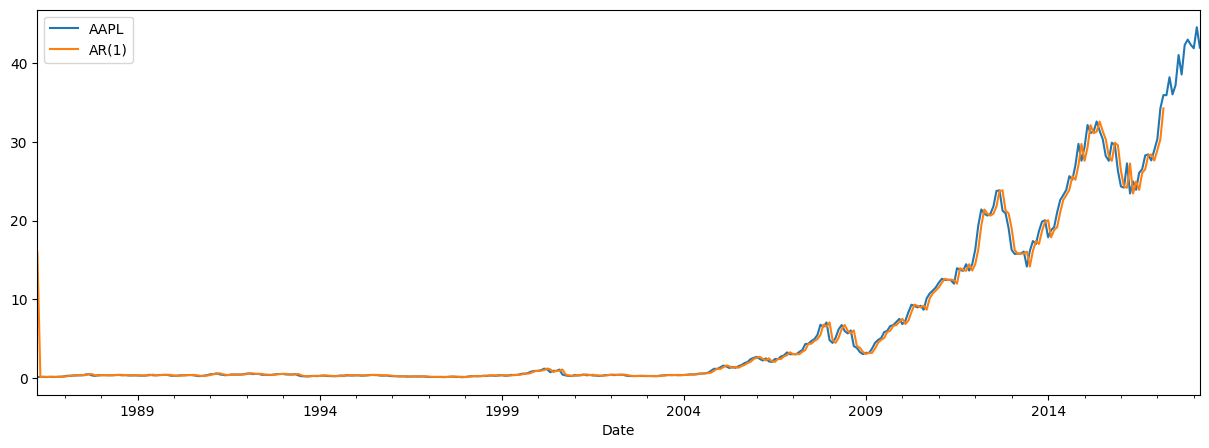

In [89]:
#Observo como quedaron mis datos entrenados por el modelo ARIMA con los datos reales de la Acción de Apple, al parecer va bien
df1[['AAPL', 'AR(1)']].plot(figsize= (15,5));

In [90]:
#Ahora lo que busco es sacar los resultados de testeo
prediction_result = arima_result.get_forecast(Ntest)

In [91]:
#A estos resultados como son una franja donde se puede mover el resultado le saco la media 
forecast = prediction_result.predicted_mean

In [92]:
forecast

2017-04-01    35.899859
2017-05-01    35.879739
2017-06-01    35.859639
2017-07-01    35.839560
2017-08-01    35.819501
2017-09-01    35.799462
2017-10-01    35.779444
2017-11-01    35.759446
2017-12-01    35.739468
2018-01-01    35.719510
2018-02-01    35.699573
2018-03-01    35.679656
Freq: MS, Name: predicted_mean, dtype: float64

In [93]:
#Agrego los datos al dataset 
df1.loc[test_idx, 'AR(1)']= forecast

<ipython-input-93-983a0cb66295>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.loc[test_idx, 'AR(1)']= forecast


In [94]:
df1.tail()

,AAPL,lstdiff,LogAAPL,logdiff,AR(1)
Date,,,,,
2017-11-01,42.96,0.70,3.760269,0.016428,35.759446
2017-12-01,42.31,-0.65,3.745023,-0.015246,35.739468
2018-01-01,41.86,-0.45,3.734331,-0.010693,35.719510
2018-02-01,44.53,2.67,3.796163,0.061832,35.699573
2018-03-01,41.94,-2.59,3.736240,-0.059923,35.679656


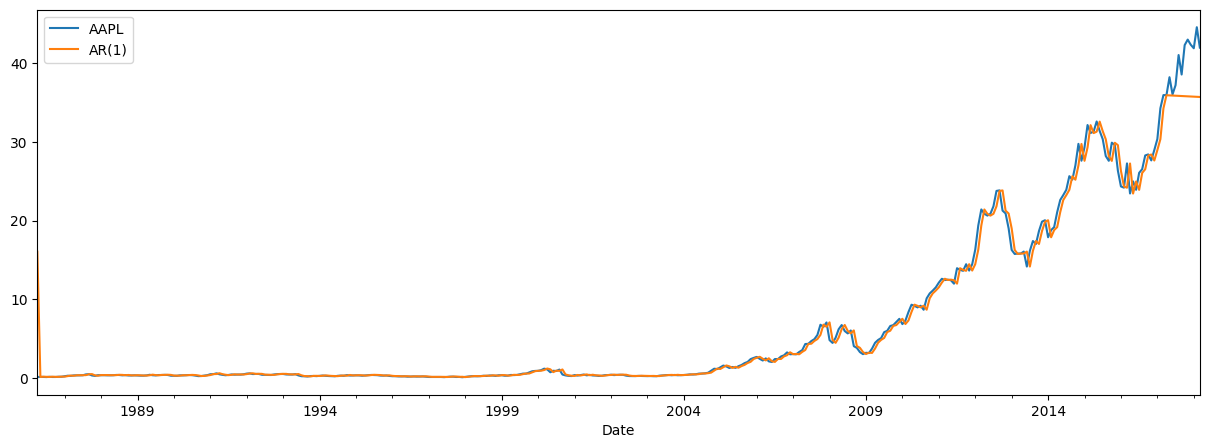

In [95]:
#Grafico nuevamente mis resultados con los datos de predicción que me arroja el dataset de testeo
df1[['AAPL', 'AR(1)']].plot(figsize = (15,5));

Por lo que se puede observar la media de los datos de la predicción no se ajusta muy bien a los datos reales, dandonos a entender que tal vez el modelo ARIMA (1,0,0) que entre comillas es un modelo autoregresivo de orden 1 no es tan bueno para la predicción de mis datos.

In [96]:
#Observo el rango de mis datos
prediction_result.conf_int()

,lower AAPL,upper AAPL
2017-04-01,34.402931,37.396788
2017-05-01,33.763836,37.995643
2017-06-01,33.269510,38.449769
2017-07-01,32.850250,38.828870
2017-08-01,32.479043,39.159959
2017-09-01,32.142025,39.456899
2017-10-01,31.830959,39.727929
2017-11-01,31.540472,39.978420
2017-12-01,31.266832,40.212103
2018-01-01,31.007321,40.431700


In [97]:
#Ahora busco graficar los datos de predicción y tambien el rango de la predicción
def plot_fit_and_forecast(result):
    fig, ax = plt.subplots(figsize = (15,5))
    ax.plot(df['AAPL'], label = 'data')
    
    #plot the curve fitted on train set
    train_pred = result.fittedvalues
    ax.plot(train.index, train_pred, color = 'green', label = 'fitted')
    
    #forecast the test set
    
    prediction_result = result.get_forecast(Ntest)
    conf_int = prediction_result.conf_int()
    lower, upper = conf_int['lower AAPL'], conf_int['upper AAPL']
    forecast = prediction_result.predicted_mean
    ax.plot(test.index, forecast, label = 'Forecast')
    ax.fill_between(test.index, \
                   lower, upper,\
                   color = 'red', alpha = 0.3)
    
    ax.legend()

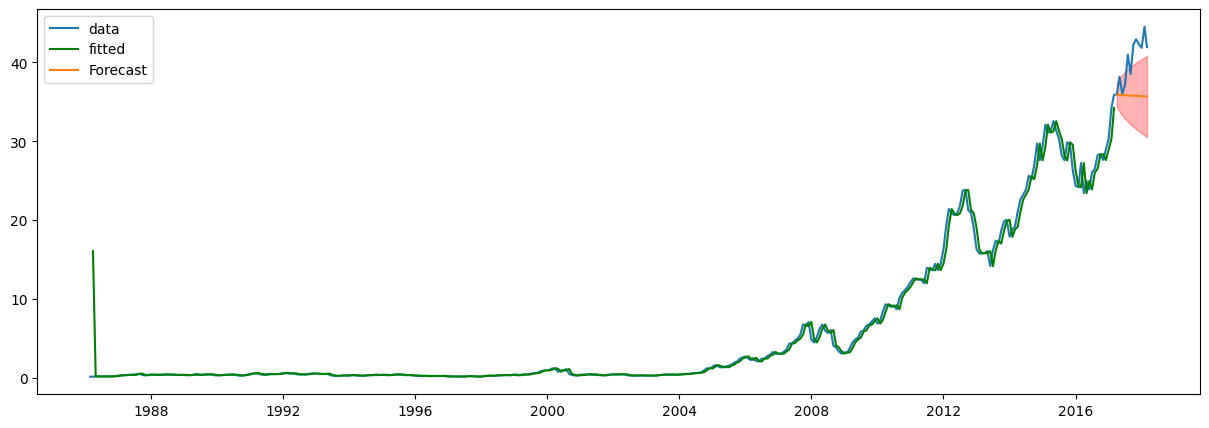

In [98]:
plot_fit_and_forecast(arima_result)

En esta grafica se puede observar como el rango de los datos de predicción es muy alto por lo que la media de la predicción no nos da un buen resultado de predicción.

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


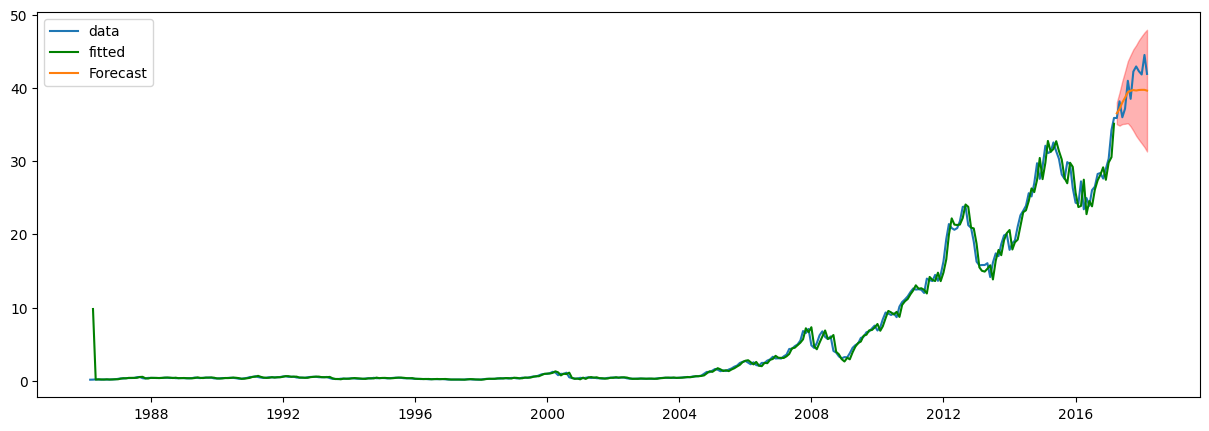

In [99]:
#Ahora lo que hago es generar un modelo para un ARIMA (10,0,0) El cual basicamente es un AR 10
arima = ARIMA(train['AAPL'], order =(10,0,0)) #AR(10)
arima_result = arima.fit()
plot_fit_and_forecast(arima_result)

Se puede observar que con un modelo ARIMA de orden (10,0,0) este puede capturar de una mejor manera la media de la predicicón aunque esta siegue siendo mala y no se ajusta bien a los datos otorgados, tambien se observa como el rango en donde se mueve la predicción cambio.

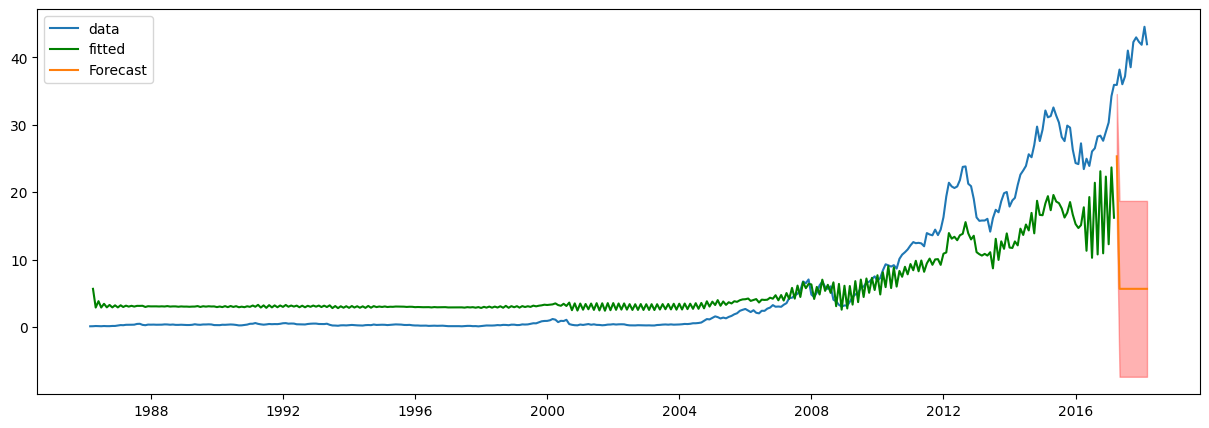

In [100]:
arima = ARIMA(train['AAPL'], order =(0,0,1)) #MA(1)
arima_result = arima.fit()
plot_fit_and_forecast(arima_result)

Se observa como el resultado obtenido por el modelo MA es aun peor que el anterior en cuanto a la predicción por ende podemos concluir que la predicción no se encuentra solo en los resagos del error.

In [124]:
#Ahora como se hizo anteriormente se saca la primera diferencia del logaritmo
df1['Log1stDiff'] = df1['LogAAPL'].diff()

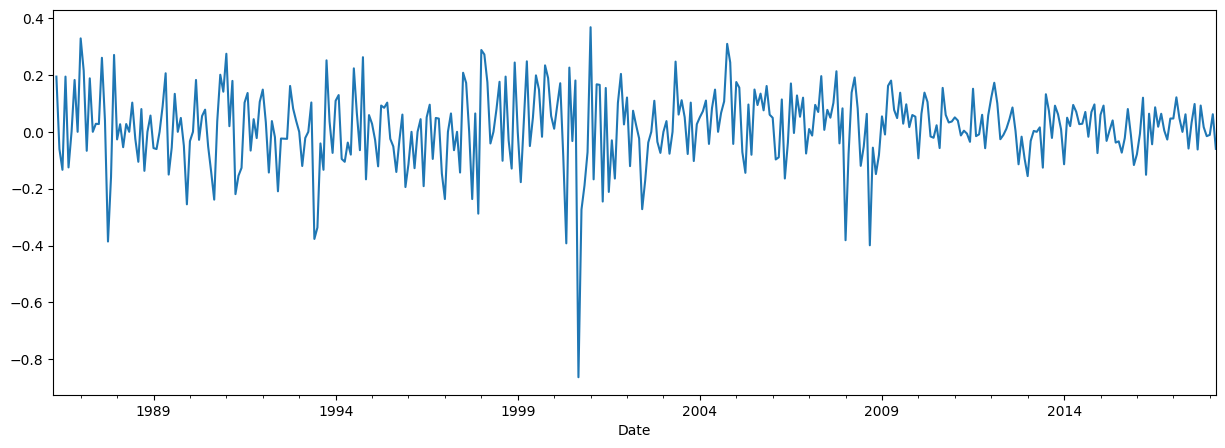

In [102]:
#Graficamos ahora esa solo diferencia para observar como se comporta
df1['Log1stDiff'].plot(figsize = (15,5));

In [103]:
def plot_fit_and_forecast(result, d, col= 'AAPL'):
    fig, ax = plt.subplots(figsize = (15,5))
    ax.plot(df1[col], label = 'data')
    
    #plot the curve fitted on train set
    train_pred = result.predict(start = train.index[d], end= train.index[-1])
    ax.plot(train.index[d:], train_pred, color = 'green',  label = 'fitted')
   
    
    #forecast the test set
    
    prediction_result = result.get_forecast(Ntest)
    conf_int = prediction_result.conf_int()
    lower, upper = conf_int[f'lower {col}'], conf_int[f'upper {col}']
    forecast = prediction_result.predicted_mean
    ax.plot(test.index, forecast, label = 'forecast')
    ax.fill_between(test.index, \
                   lower, upper,\
                   color = 'red', alpha = 0.3)
    
    ax.legend()

In [104]:
arima = ARIMA(train['AAPL'], order = (8,1,1))
arima_result_811 = arima.fit()

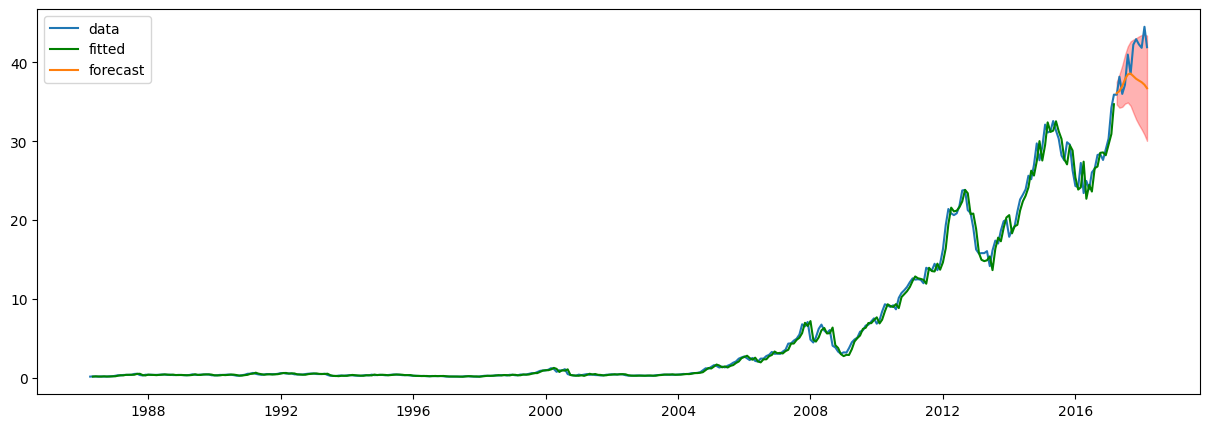

In [105]:
plot_fit_and_forecast(arima_result_811,1)

Ahora buscamos evaluar la predicción con un modelo ARIMA de orden (8,1,1) el cual observamos mejora bstante en comparación del pimer modelo pero sigue estando muy por debajo de la predicción que buscamos.

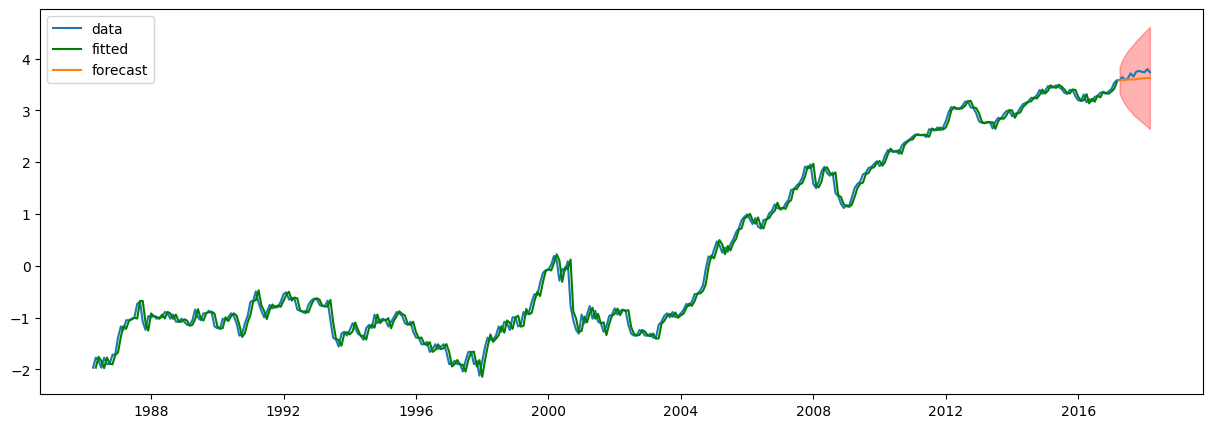

In [128]:
arima = ARIMA(train['LogAAPL'], order = (8,1,1))
arima_result_log811 = arima.fit()
plot_fit_and_forecast(arima_result_log811,1, col='LogAAPL')

Hacemos el mismo procedimiento pero esta vez usando el valor de el logaritmo natural del precio de la acción y observamos que mejora sacando la tendencia alcista en general pero no mucho.

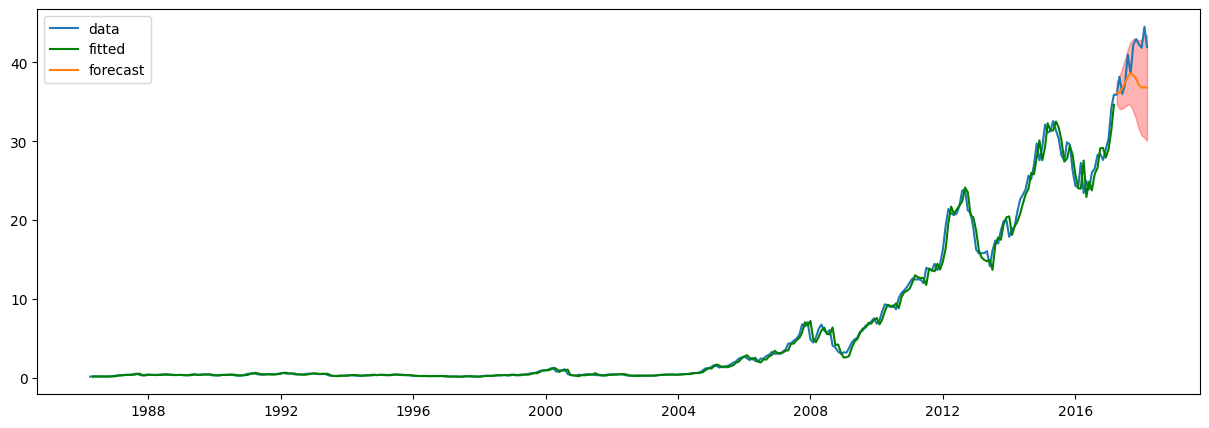

In [107]:
arima = ARIMA(train['AAPL'], order = (12,1,0))
arima_result_1210 = arima.fit()
plot_fit_and_forecast(arima_result_1210,1, col='AAPL')

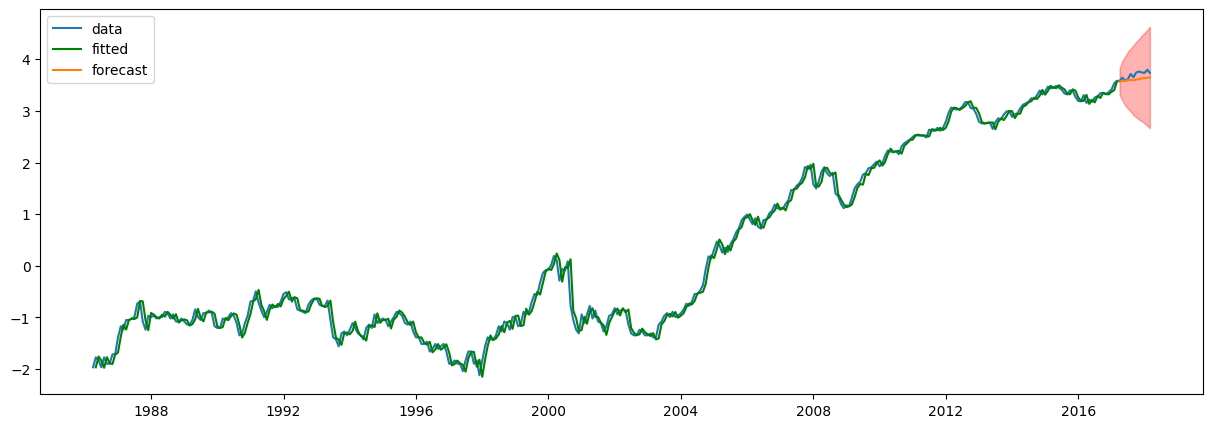

In [108]:
arima = ARIMA(train['LogAAPL'], order = (12,1,0))
arima_result_log1210 = arima.fit()
plot_fit_and_forecast(arima_result_log1210,1, col='LogAAPL')

Se evidencia un comportamiento similar en las dos graficas anteriores en las cuales el modelo que se saca con un ARIMA (12,1,0) es mejor en cuanto a ver la tendencia general de la predicción con los datos del logaritmo del precio de las acciones de Apple que cuando solo usamos este dato.

In [109]:
#Ahora defino una función para sacar la predicción y sacar la raiz del error cuadratico medio
def rmse(result, is_logged):
    forecast = result.forecast(Ntest)
    if is_logged:
        forecast = np.exp(forecast)
    t = test['AAPL']
    y = forecast
    return np.sqrt(np.mean((t-y)**2))

In [110]:
print("ARIMA(8,1,1):", rmse(arima_result_811, False))
print("ARIMA(8,1,1) logged:", rmse(arima_result_log811, True))
print("ARIMA(12,1,0):", rmse(arima_result_1210, False))
print("ARIMA(12,1,0) logged:", rmse(arima_result_log1210, True))

ARIMA(8,1,1): 3.805094625666042
ARIMA(8,1,1) logged: 4.219475651391515
ARIMA(12,1,0): 3.984704424492779
ARIMA(12,1,0) logged: 3.9510002028424513


Aca se observa como obtenemos el menor valor de la raiz del error cuadratico medio cuando usamos un modelos ARIMA de order (8,1,1).

In [111]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.3 MB/s eta 0:00:00


In [112]:
import pmdarima as pm

In [113]:
model = pm.auto_arima(train['AAPL'],
                     trace = True,
                     suppress_warnings = True,
                     seasonal = True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(1,0,1)[12]             : AIC=inf, Time=2.82 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1062.213, Time=0.06 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=966.039, Time=0.14 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=852.545, Time=0.38 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=850.562, Time=0.12 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=852.545, Time=0.35 sec
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=854.545, Time=1.26 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=849.907, Time=0.41 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=851.885, Time=1.14 sec
 ARIMA(1,2,1)(0,0,1)[12]             : AIC=851.886, Time=1.07 sec
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=853.049, Time=2.80 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=970.043, Time=0.09 sec
 ARIMA(2,2,1)(0,0,0)[12]             : AIC=851.876, Time=0.58 sec
 ARIMA(1,2,2)(0,0,0)[12]             : AIC=850.212, Time=1.05 sec
 ARIMA(0,2,2)(0,0,0)[12]            

Mediante el Criterio de información de akaike se observo que el mejor modelo es un ARIMA (1,2,1)(0,0,0) por ende este es el que vamos a usar para nuestro modelo de predicción.

In [114]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  372
Model:               SARIMAX(1, 2, 1)   Log Likelihood                -421.953
Date:                Mon, 03 Apr 2023   AIC                            849.907
Time:                        03:40:30   BIC                            861.647
Sample:                    04-01-1986   HQIC                           854.570
                         - 03-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0858      0.025      3.366      0.001       0.036       0.136
ma.L1         -0.9845      0.007   -139.345      0.000      -0.998      -0.971
sigma2         0.5678      0.019     30.261      0.000       0.531       0.605
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):              1118.67
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):             720.40   Skew:                            -0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [115]:
test_pred, confint = model.predict(n_periods = Ntest, return_conf_int = True)

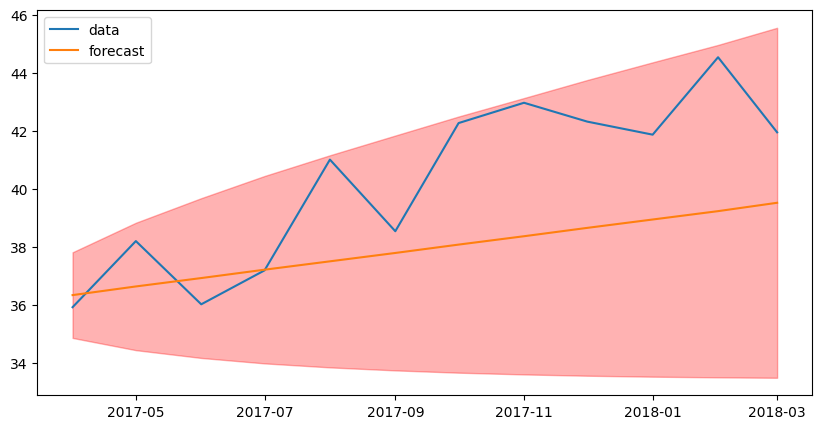

In [116]:
fig, ax =plt.subplots(figsize= (10,5))
ax.plot(test.index, test['AAPL'], label='data')
ax.plot(test.index, test_pred, label='forecast')
ax.fill_between(test.index, confint[:,0], confint[:,1], color='red', alpha=0.3)

ax.legend();

In [117]:
train_pred = model.predict_in_sample()

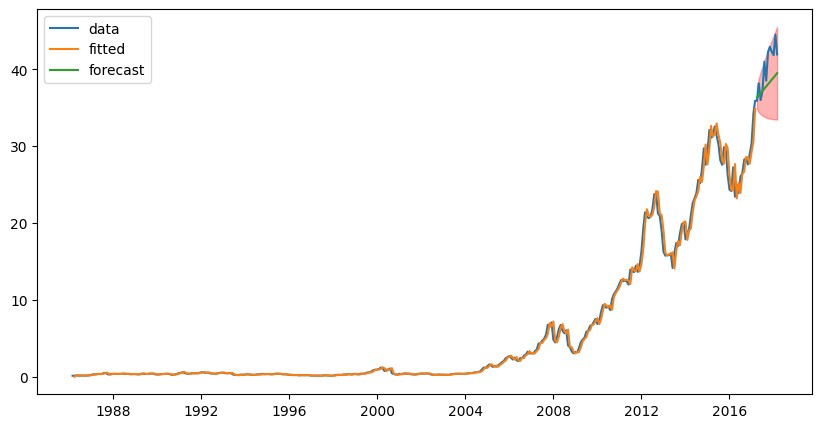

In [118]:
fig, ax =plt.subplots(figsize= (10,5))
ax.plot(df.index, df['AAPL'], label='data')
ax.plot(train.index, train_pred, label='fitted')
ax.plot(test.index, test_pred, label='forecast')
ax.fill_between(test.index, confint[:,0], confint[:,1], color='red', alpha=0.3)

ax.legend();

In [119]:
logmodel = pm.auto_arima(train['LogAAPL'],
                     trace = True,
                     suppress_warnings = True,
                     seasonal = True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=2.66 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-440.049, Time=0.11 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-438.924, Time=0.82 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-439.104, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-437.389, Time=0.06 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=-439.219, Time=0.28 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=-439.348, Time=0.28 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=1.34 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-439.442, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=-439.444, Time=0.28 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-437.444, Time=1.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12] intercept
Total fit time: 7.717 seconds


In [120]:
logmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  372
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 222.025
Date:                Mon, 03 Apr 2023   AIC                           -440.049
Time:                        03:40:38   BIC                           -432.217
Sample:                    04-01-1986   HQIC                          -436.938
                         - 03-01-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0150      0.008      1.988      0.047       0.000       0.030
sigma2         0.0177      0.001     23.490      0.000       0.016       0.019
===================================================================================
Ljung-Box (L1) (Q):                   1.40   Jarque-Bera (JB):               463.58
Prob(Q):                              0.24   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                            -1.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

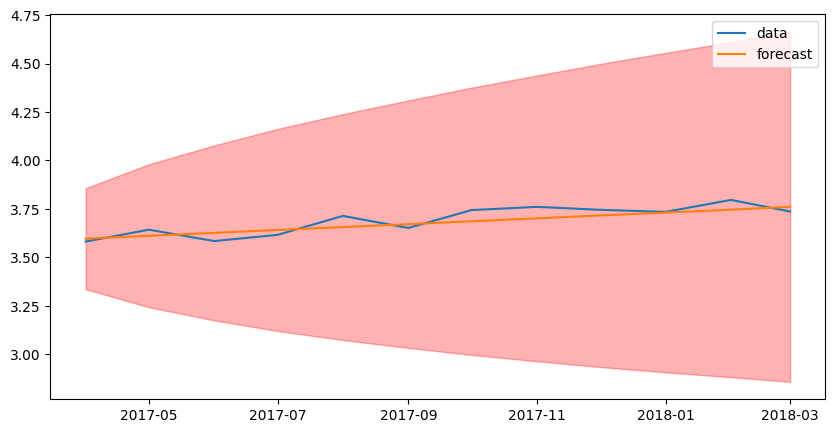

In [121]:
test_pred_log, confint = logmodel.predict(n_periods = Ntest, return_conf_int = True)
fig, ax =plt.subplots(figsize= (10,5))
ax.plot(test.index, test['LogAAPL'], label='data')
ax.plot(test.index, test_pred_log, label='forecast')
ax.fill_between(test.index, confint[:,0], confint[:,1], color='red', alpha=0.3)

ax.legend();

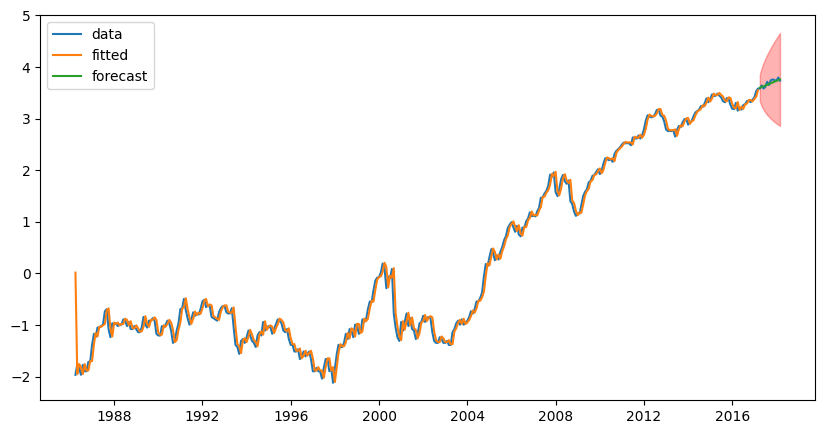

In [133]:
train_pred_log = logmodel.predict_in_sample()
fig, ax =plt.subplots(figsize= (10,5))
ax.plot(df1.index, df1['LogAAPL'], label='data')
ax.plot(train.index, train_pred_log, label='fitted')
ax.plot(test.index, test_pred_log, label='forecast')
ax.fill_between(test.index, confint[:,0], confint[:,1], color='red', alpha=0.3)

ax.legend();

Se observa como el mejor modelo fue el que usaba un Modelo ARIMA (1,2,1)(0,0,0) con el logaritmo del precio de la acción de apple para poder predecir esta en los siguientes doce datos. No es la mejor predicción que existe pero si la mejor que se pudo obtener. Esto se puede deber a que al tener una serie no estacionaria en un principio necesitamos volverla estacionaria mediante transformaciones las cuales se pueden lograr aplicando el logaritmo sobre la serie y estos resultados pueden mejorar aplicando una diferencia sobre este logaritmo.

In [135]:
model.predict(Ntest)

2017-04-01    36.326966
2017-05-01    36.625586
2017-06-01    36.914912
2017-07-01    37.203441
2017-08-01    37.491902
2017-09-01    37.780356
2017-10-01    38.068810
2017-11-01    38.357265
2017-12-01    38.645719
2018-01-01    38.934173
2018-02-01    39.222627
2018-03-01    39.511081
Freq: MS, dtype: float64

In [136]:
#Para utlizar la función realizando la transformación inversa del logaritmo cambiamos .forecast por .predict
def rmse1(result, is_logged):
    forecast = result.predict(n_periods = Ntest)
    if is_logged:
        forecast = np.exp(forecast)
    t = test["AAPL"]
    y = forecast
    return np.sqrt(np.mean((t-y)**2))

In [137]:
print("Non-logged RMSE:", rmse1(model, False))

Non-logged RMSE: 3.042968844125607


In [138]:
#forecast RMSE
def rmse2(t,y):
    return np.sqrt(np.mean((t-y)**2))

In [139]:
print("Non-logged RMSE:", rmse2(test['AAPL'], test_pred))

Non-logged RMSE: 3.042968844125607


In [140]:
print("Logged RMSE:", rmse2(test['AAPL'], np.exp(test_pred_log)))

Logged RMSE: 1.5813931879807377


In [141]:
print("Logged RMSE:", rmse1(logmodel, True))

Logged RMSE: 1.5813931879807377


Se observa como al usar el logaritmo de la serie de tiempo la raiz del error cuadratico medio disminuyo casi que a la mitad.